<a href="https://colab.research.google.com/github/hoonzi-s/APC/blob/main/%231ALK_213BTMRVP_R6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

## Get Data

In [ ]:
data_origin = pd.read_csv('https://raw.githubusercontent.com/hoonzi-s/APC/main/%231%20ALK%20RVP%20CSV.csv', index_col = 0)
data_origin.info()
data_origin.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2753 entries, 2014-09-16 to 2022-06-30
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RVP_LAB         2753 non-null   float64
 1   S.B5.213TI2804  2753 non-null   float64
 2   S.B5.213PI2806  2753 non-null   float64
 3   S.B5.213FC2602  2753 non-null   float64
dtypes: float64(4)
memory usage: 107.5+ KB


,RVP_LAB,S.B5.213TI2804,S.B5.213PI2806,S.B5.213FC2602
count,2753.00000,2753.000000,2753.000000,2753.000000
mean,39.41551,133.889974,335.177430,85.890540
std,3.53523,3.471188,29.578899,10.688965
min,28.50000,98.364672,293.412469,33.324527
25%,37.50000,131.923775,318.182670,81.066149
50%,39.00000,133.375011,325.641719,88.489940
75%,40.80000,136.082275,339.128497,92.699854
max,98.60000,145.946073,516.111992,112.931605


In [ ]:
data_origin.columns = ['RVP', 'T', 'P', 'F', 'R']
data = data_origin[(data_origin.iloc[:, 0] < 70) & (data_origin.iloc[:, 1] > 120)]
data['RF'] = data['R'] / data['F']
# data.iloc[:, 1] += 273.15     # to Absolute
# data.iloc[:, 2] += 101.325    # to Absolute
# lab = data.iloc[:, 0]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [ ]:
results = pd.DataFrame(columns=['Alpha', 'train_R2', 'test_R2', 'R2', 'MAE', 'MSE', 'coeffs', 'intercept'])
results

,Alpha,train_R2,test_R2,R2,MAE,MSE,coeffs,intercept


# Existing Inferential (PCT by Song)

In [ ]:
T = data['T']
P = data['P']/101.325
lnP = np.log(P)

exist = np.exp(51.596*(311-T*(16052-1902*lnP)/(16052-P*lnP))/(1902-T*(16052-1902*lnP)/(16052-P*lnP)))*101.325-4.50907
exist

2014-09-16    35.539507
2014-09-17    33.800584
2014-09-18    34.720362
2014-09-19    35.013853
2014-09-20    37.005404
                ...    
2022-06-26    48.077813
2022-06-27    51.949963
2022-06-28    57.963941
2022-06-29    52.213072
2022-06-30    53.660578
Length: 2750, dtype: float64

In [ ]:
mae = MAE(lab, exist)
mse = MSE(lab, exist)
r2 = r2_score(lab, exist)   # 낮을 수록 좋은 것
r2_inv = 1 - r2

new = pd.DataFrame({'Solution': 'exist',
                    'R2' : r2,
                    '1-R2' : r2_inv,
                    'MAE': mae, 
                    'MSE': mse}, 
                   index = [0])
information = pd.concat([information, new])
new

,Solution,R2,1-R2,MAE,MSE
0,exist,0.303459,0.696541,2.128567,7.802287


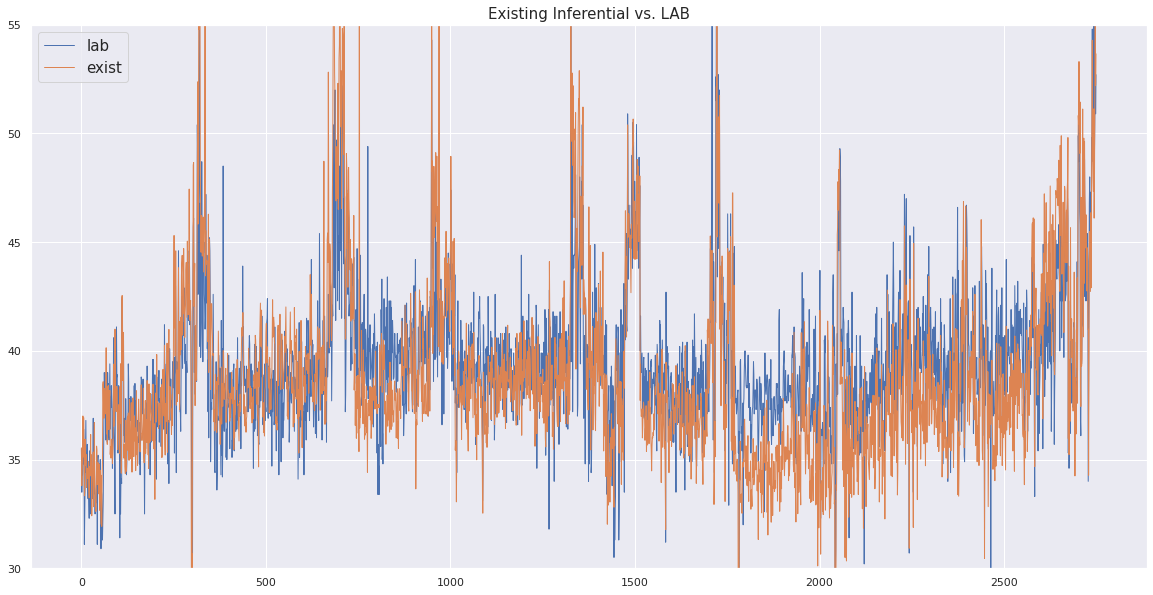

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), lab, label = 'lab', lw = 1)
plt.plot(np.arange(2750), exist, label = 'exist', lw = 1)
plt.ylim(30, 55)
plt.legend(fontsize = 15)
plt.title('Existing Inferential vs. LAB', fontsize = 15)
plt.savefig('inf_existing.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# LinearRegression

In [ ]:
input = data[['T', 'P', 'F']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
sc = StandardScaler()
sc.fit(train_input)
input_poly = sc.transform(input_poly)
train_poly = sc.transform(train_input)
test_poly = sc.transform(test_input)

model = LinearRegression()
model.fit(train_poly, train_target)

train_R2.append(model.score(train_poly, train_target))
test_R2.append(model.score(test_poly, test_target))
inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
mae.append(MAE(target, inferential))
mse.append(MSE(target, inferential))
r2.append(r2_score(target, inferential))

In [ ]:
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",LinearRegression,NaN,Standard,0.596053,0.560976,0.586647,0.413353,1.571838,4.630157


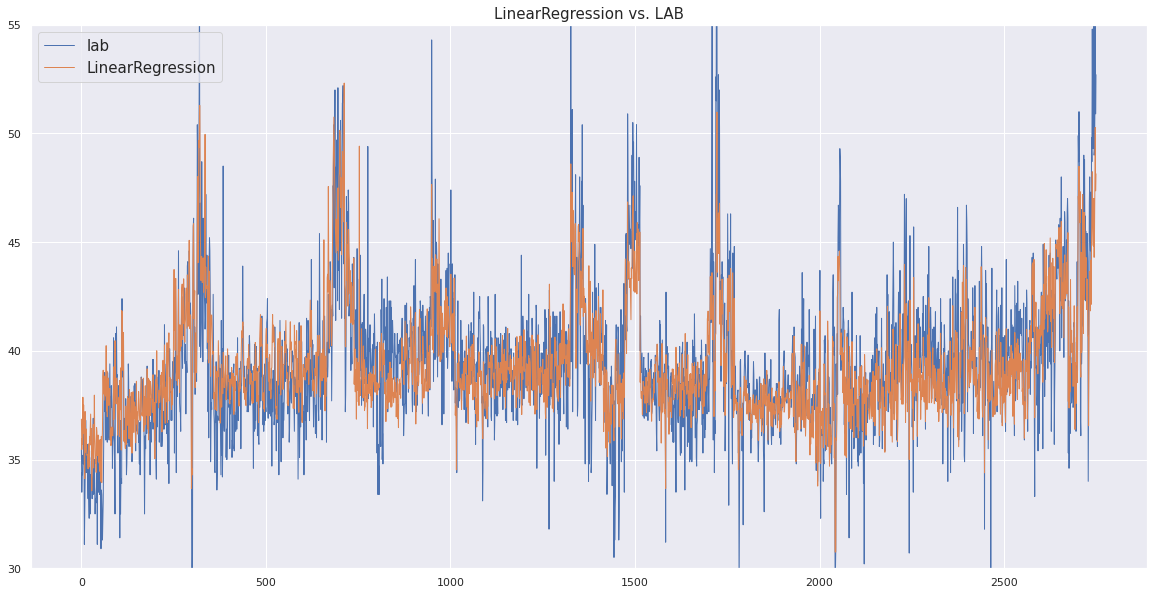

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), lab, label = 'lab', lw = 1)
plt.plot(np.arange(2750), inferential, label = 'LinearRegression', lw = 1)
plt.ylim(30, 55)
plt.legend(fontsize = 15)
plt.title('LinearRegression vs. LAB', fontsize = 15)
plt.savefig('inf_linearregression.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)
train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)

sc = StandardScaler()
sc.fit(train_input)
input_poly = sc.transform(input_poly)
train_poly = sc.transform(train_input)
test_poly = sc.transform(test_input)

xgb = XGBRegressor()
xgb.fit(train_poly, train_target)
print(f'train_R2: {xgb.score(train_poly, train_target)}')
print(f'test_R2: {xgb.score(test_poly, test_target)}')
print(f'R2: {r2_score(target, xgb.predict(input_poly))}')
inferential = xgb.predict(input_poly)
print(f'MAE: {MAE(target, inferential)}')
print(f'MSE: {MSE(target, inferential)}')

[04:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_R2: 0.6964234698463669
test_R2: 0.6072179783182994
R2: 0.671258164787376
MAE: 1.4269713883833453
MSE: 3.682392533653613


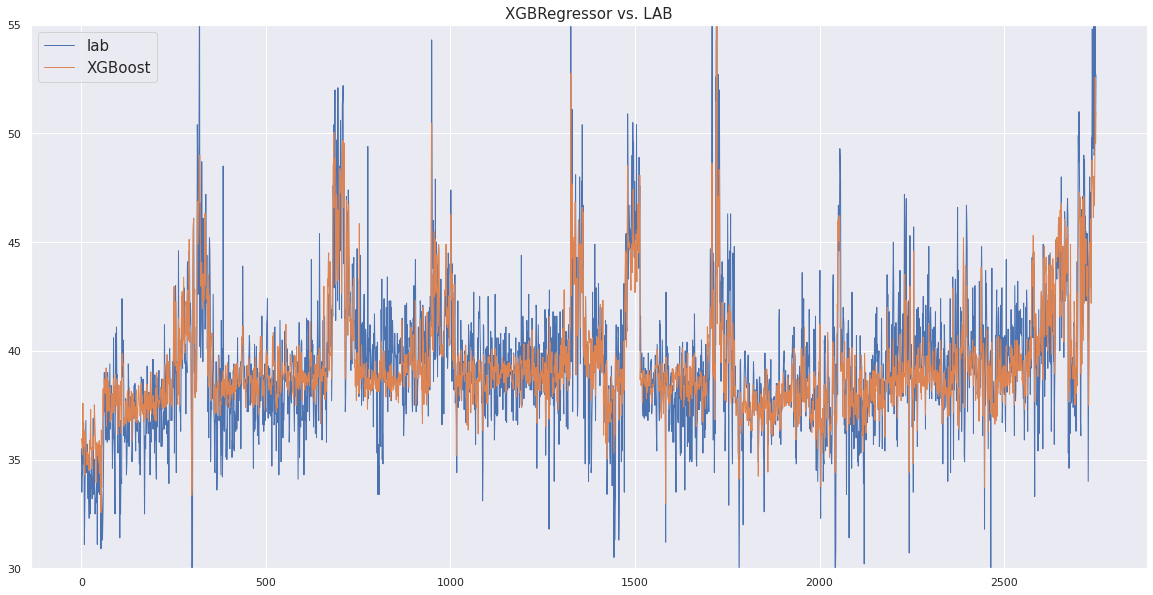

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, label = 'lab', lw = 1)
plt.plot(np.arange(2750), inferential, label = 'XGBoost', lw = 1)
plt.ylim(30, 55)
plt.legend(fontsize = 15)
plt.title('XGBRegressor vs. LAB', fontsize = 15)
plt.savefig('inf_xgbregressor.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# Lasso 0.01 ~ 0.09

In [ ]:
results = pd.DataFrame(columns=['Alpha', 'train_R2', 'test_R2', 'R2', 'MAE', 'MSE', 'coeffs', 'intercept'])
alphas = np.arange(0.01, 0.1, 0.01)
input = data[['T', 'P', 'F']]
target = data['RVP']

for a in alphas:
  for i in range(10):
    pf = PolynomialFeatures()
    pf.fit(input)
    input_poly = pf.transform(input)

    train_R2 = []
    test_R2 = []
    mae = []
    mse = []
    r2 = []

    vars = 'Poly T, P, F'
    soln = 'Lasso'
    scaler = 'Standard'

    train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
    sc = StandardScaler()
    sc.fit(train_input)
    input_poly = sc.transform(input_poly)
    train_poly = sc.transform(train_input)
    test_poly = sc.transform(test_input)

    model = Lasso(alpha = a, max_iter = 10000000)
    model.fit(train_poly, train_target)
    inferential = model.predict(input_poly)

    result = pd.DataFrame({'Alpha': a, 
                        'train_R2': model.score(train_poly, train_target), 
                        'test_R2': model.score(test_poly, test_target), 
                        'R2': model.score(input_poly, target), 
                        'MAE': MAE(target, inferential), 
                        'MSE': MSE(target, inferential),
                        # 'coeffs': model.coef_,
                        'intercept': model.intercept_}, index = [0])
    results = pd.concat([results, result])

results.groupby(by = 'Alpha').mean()

,train_R2,test_R2,R2,MAE,MSE,intercept
Alpha,,,,,,
0.01,0.573279,0.557197,0.569616,1.590159,4.820937,39.405881
0.02,0.572496,0.553538,0.569082,1.590872,4.826915,39.421198
0.03,0.567377,0.571852,0.568921,1.591465,4.828715,39.395533
0.04,0.565977,0.571918,0.568230,1.592752,4.836457,39.389936
0.05,0.570569,0.557948,0.568105,1.592838,4.837855,39.404364
0.06,0.570637,0.556305,0.566538,1.596160,4.855417,39.401856
0.07,0.553755,0.588657,0.563802,1.602162,4.886063,39.381527
0.08,0.560060,0.572934,0.563499,1.601550,4.889454,39.389902
0.09,0.555634,0.575638,0.561736,1.605716,4.909206,39.394752


# Lasso 0.001 ~ 0.019

In [ ]:
results = pd.DataFrame(columns=['Alpha', 'train_R2', 'test_R2', 'R2', 'MAE', 'MSE', 'coeffs', 'intercept'])
alphas = np.arange(0.001, 0.02, 0.001)
input = data[['T', 'P', 'F']]
target = data['RVP']

for a in alphas:
  for i in range(10):
    pf = PolynomialFeatures()
    pf.fit(input)
    input_poly = pf.transform(input)

    train_R2 = []
    test_R2 = []
    mae = []
    mse = []
    r2 = []

    vars = 'Poly T, P, F'
    soln = 'Lasso'
    scaler = 'Standard'

    train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
    sc = StandardScaler()
    sc.fit(train_input)
    input_poly = sc.transform(input_poly)
    train_poly = sc.transform(train_input)
    test_poly = sc.transform(test_input)

    model = Lasso(alpha = a, max_iter = 10000000)
    model.fit(train_poly, train_target)
    inferential = model.predict(input_poly)

    result = pd.DataFrame({'Alpha': a, 
                        'train_R2': model.score(train_poly, train_target), 
                        'test_R2': model.score(test_poly, test_target), 
                        'R2': model.score(input_poly, target), 
                        'MAE': MAE(target, inferential), 
                        'MSE': MSE(target, inferential),
                        # 'coeffs': model.coef_,
                        'intercept': model.intercept_}, index = [0])
    results = pd.concat([results, result])

results.groupby(by = 'Alpha').mean()

,train_R2,test_R2,R2,MAE,MSE,intercept
Alpha,,,,,,
0.001,0.584354,0.558418,0.578719,1.577170,4.718963,39.415371
0.002,0.574302,0.577371,0.576411,1.579744,4.744822,39.400211
0.003,0.567854,0.594721,0.575796,1.581571,4.751709,39.385361
0.004,0.581156,0.556019,0.574770,1.581390,4.763201,39.424364
0.005,0.570891,0.577263,0.573252,1.584231,4.780203,39.415930
0.006,0.570668,0.573549,0.571721,1.586975,4.797358,39.411060
0.007,0.563559,0.585307,0.570127,1.588980,4.815211,39.392425
0.008,0.570490,0.566134,0.569589,1.590739,4.821231,39.406043
0.009,0.569880,0.568316,0.569659,1.590340,4.820454,39.407452


In [ ]:
results

,Alpha,train_R2,test_R2,R2,MAE,MSE,coeffs,intercept
0,0.001,0.590753,0.535519,0.577936,1.577586,4.727743,NaN,39.427688
0,0.001,0.574627,0.589094,0.578922,1.580557,4.716692,NaN,39.358567
0,0.001,0.600981,0.498993,0.578020,1.578256,4.726799,NaN,39.430879
0,0.001,0.581260,0.566109,0.577269,1.580426,4.735208,NaN,39.339715
0,0.001,0.573627,0.591147,0.578307,1.576603,4.723588,NaN,39.424497
...,...,...,...,...,...,...,...,...
0,0.019,0.568567,0.569121,0.568805,1.595183,4.830021,NaN,39.368287
0,0.019,0.571557,0.561556,0.569105,1.591425,4.826661,NaN,39.428915
0,0.019,0.581765,0.532938,0.569238,1.592454,4.825170,NaN,39.413598
0,0.019,0.586652,0.518973,0.569910,1.589320,4.817644,NaN,39.441630


In [ ]:
results = pd.DataFrame(columns=['Alpha', 'train_R2', 'test_R2', 'R2', 'MAE', 'MSE', 'coeffs', 'intercept'])
alphas = np.arange(0.001, 0.02, 0.001)
input = data[['T', 'P', 'F']]
target = data['RVP']

for a in alphas:
  for i in range(10):
    pf = PolynomialFeatures()
    pf.fit(input)
    input_poly = pf.transform(input)

    train_R2 = []
    test_R2 = []
    mae = []
    mse = []
    r2 = []

    train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
    # sc = StandardScaler()
    # sc.fit(train_input)
    # input_poly = sc.transform(input_poly)
    # train_poly = sc.transform(train_input)
    # test_poly = sc.transform(test_input)

    model = Lasso(alpha = a, max_iter = 10000000)
    model.fit(train_input, train_target)
    inferential = model.predict(input_poly)

    result = pd.DataFrame({'Alpha': a, 
                        'train_R2': model.score(train_input, train_target), 
                        'test_R2': model.score(test_input, test_target), 
                        'R2': model.score(input_poly, target), 
                        'MAE': MAE(target, inferential), 
                        'MSE': MSE(target, inferential),
                        # 'coeffs': model.coef_,
                        'intercept': model.intercept_}, index = [0])
    results = pd.concat([results, result])
    print(f'alpha = {a:.3f}, zeros = {np.sum(model.coef_ == 0)}')
# results.groupby(by = 'Alpha').mean()

alpha = 0.001, zeros = 2
alpha = 0.001, zeros = 2
alpha = 0.001, zeros = 2
alpha = 0.001, zeros = 2
alpha = 0.001, zeros = 2
alpha = 0.001, zeros = 2
alpha = 0.001, zeros = 2
alpha = 0.001, zeros = 2
alpha = 0.001, zeros = 2
alpha = 0.001, zeros = 2
alpha = 0.002, zeros = 2
alpha = 0.002, zeros = 2
alpha = 0.002, zeros = 2
alpha = 0.002, zeros = 2
alpha = 0.002, zeros = 2
alpha = 0.002, zeros = 2
alpha = 0.002, zeros = 3
alpha = 0.002, zeros = 2
alpha = 0.002, zeros = 2
alpha = 0.002, zeros = 2
alpha = 0.003, zeros = 2
alpha = 0.003, zeros = 2
alpha = 0.003, zeros = 3
alpha = 0.003, zeros = 2
alpha = 0.003, zeros = 2
alpha = 0.003, zeros = 3
alpha = 0.003, zeros = 2
alpha = 0.003, zeros = 2
alpha = 0.003, zeros = 2
alpha = 0.003, zeros = 2
alpha = 0.004, zeros = 2
alpha = 0.004, zeros = 2
alpha = 0.004, zeros = 2
alpha = 0.004, zeros = 2
alpha = 0.004, zeros = 3
alpha = 0.004, zeros = 2
alpha = 0.004, zeros = 2
alpha = 0.004, zeros = 2
alpha = 0.004, zeros = 2
alpha = 0.004, zeros = 2


In [ ]:
np.sum(model.coef_==0)

7

# Defining coefficients and intercept

In [ ]:
results = pd.DataFrame(columns=['Alpha', 'train_R2', 'test_R2', 'R2', 'MAE', 'MSE', 'coeffs', 'intercept'])
input = data[['T', 'P', 'F']]
target = data['RVP']
train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
coeffs = []
intercepts = []

for i in range(10):
  pf = PolynomialFeatures(include_bias = False)
  pf.fit(input)
  input_poly = pf.transform(input)
  means = input_poly.mean(axis = 0)
  stds = input_poly.std(axis = 0)
  input_scaled = (input_poly - means) / stds
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = 0.01, max_iter = 10000000)
  model.fit(train_input, train_target)
  inferential = model.predict(input_scaled)

  train_R2.append(model.score(train_input, train_target))
  test_R2.append(model.score(test_input, test_target))
  r2.append(r2_score(target, inferential))
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  coeffs.append(model.coef_)
  intercepts.append(model.intercept_)

index = np.argmax(r2)

In [ ]:
r2

[-879.9778648540689,
 -837.258180035037,
 -126.7013515283596,
 -11.691493568741558,
 -13.22936648691459,
 -80.87461754598503,
 -753.7919285233012,
 -13.19090830266659,
 -268.0699219324258,
 -1133.2794353402624]

In [ ]:
input_poly = pf.transform(input)
input_poly
means = input_poly.mean(axis = 0)
means
stds = input_poly.std(axis = 0)
stds
input_scaled = (input_poly - means) / stds
input_scaled

array([[        nan,  0.86225145,  0.00460776, ..., -0.02722552,
         0.30260678,  0.33879017],
       [        nan,  1.46091681,  0.1034868 , ...,  0.06507886,
         0.31803941,  0.29683943],
       [        nan,  1.25785053,  0.14885655, ...,  0.10763812,
         0.52205095,  0.54241577],
       ...,
       [        nan, -1.48544915,  2.31473323, ...,  2.29026604,
         0.95325456, -0.16429421],
       [        nan, -1.2763917 ,  1.48887632, ...,  1.42314874,
         0.10944495, -0.69444843],
       [        nan, -1.06518209,  1.95021893, ...,  1.90224113,
         0.42982038, -0.55953509]])

In [ ]:
coeffs

[array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  2.72514316e+00,
        -6.67860561e-04,  6.76885677e-04, -6.71805970e-03, -2.08043288e-04,
         2.24950628e-04, -7.80489714e-04]),
 array([ 0.00000000e+00, -0.00000000e+00,  6.27732596e-01,  1.04870876e+00,
        -3.33923634e-04, -9.05305537e-04, -2.25209630e-03, -1.22229504e-04,
        -3.89683132e-04, -4.01145700e-05]),
 array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  2.83389863e+00,
        -6.25632895e-04,  7.11959970e-04, -7.22883559e-03, -2.48077408e-04,
         4.87870733e-04, -8.57942060e-04]),
 array([ 0.00000000e+00, -0.00000000e+00,  6.06597387e-01,  1.95347044e+00,
        -1.02960582e-06, -9.65285539e-04, -4.84579297e-03, -1.32096524e-04,
         2.03716875e-04, -6.67930301e-04]),
 array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  3.21552168e+00,
        -4.76023084e-04,  6.38718924e-04, -8.43488186e-03, -2.37599965e-04,
         7.16973615e-04, -7.96193420e-04]),
 array([ 0.00000000e

In [ ]:
r2

[0.584718277692001,
 0.5825399161238932,
 0.5852954460237838,
 0.5842552316339561,
 0.5858821463958168,
 0.5847843406157087,
 0.58304047332733,
 0.5846994380657216,
 0.5843035125931344,
 0.5819034849468367]

In [ ]:
index

4

In [ ]:
r2[index]

0.5858821463958168

In [ ]:
max(r2)

0.5858821463958168

In [ ]:
print(coeffs[index])
print(intercepts[index])

[ 0.00000000e+00  0.00000000e+00  2.16931228e-01  3.41620875e+00
 -1.34612860e-04  3.15437475e-05 -8.72735613e-03 -1.80098771e-04
  5.08970583e-04 -7.52435801e-04]
-5.968218255884146


In [ ]:
pf.get_feature_names_out()

array(['1', 'T', 'P', 'F', 'T^2', 'T P', 'T F', 'P^2', 'P F', 'F^2'],
      dtype=object)

In [ ]:
inferential = -2.71932095 * data['T'] + 3.10141963 * data['P'] - 0.42649066 * data['T'] * data['P'] + 39.40628375061378
print(r2_score(target, inferential))
print(MAE(target, inferential))
print(MSE(target, inferential))

-512301348.8922055
75555.2918304823
5738529337.4771595


In [ ]:
target

2014-09-16    35.5
2014-09-17    33.5
2014-09-18    34.4
2014-09-19    34.3
2014-09-20    35.2
              ... 
2022-06-26    49.2
2022-06-27    50.9
2022-06-28    56.8
2022-06-29    50.9
2022-06-30    52.7
Name: RVP, Length: 2750, dtype: float64

In [ ]:
inferential

2014-09-16   -76056.318759
2014-09-17   -76936.533836
2014-09-18   -77039.508834
2014-09-19   -76240.868177
2014-09-20   -78661.478431
                  ...     
2022-06-26   -80751.214880
2022-06-27   -83283.891575
2022-06-28   -86090.009730
2022-06-29   -82120.698869
2022-06-30   -84572.290377
Length: 2750, dtype: float64

In [ ]:
StandardScaler.inverse_transform(input_poly)

TypeError: ignored

In [ ]:
input = data[['T', 'P', 'F']]
target = data['RVP']

In [ ]:
pf = PolynomialFeatures()
pf.fit(input)
input_poly = pd.DataFrame(pf.transform(input))

means = input_poly.mean(axis = 0)
stds = input_poly.std(axis = 0)

In [ ]:
stds

0        0.000000
1        3.320623
2       29.581203
3       10.668001
4     2707.295001
5    13026.970315
6     4267.644146
7    27763.769440
8     5608.870550
9     1714.609677
dtype: float64

In [ ]:
inferential = -2.71932095 * (data['T'] - means[1]) / stds[1] + 3.10141963 * (data['P'] - means[2]) / stds[2] - 0.42649066 * (data['T'] * data['P'] - means[6]) / stds[6] + 39.40628375061378
print(r2_score(target, inferential))
print(MAE(target, inferential))
print(MSE(target, inferential))

-17.726294826897266
14.259708170680208
209.76207122820958


In [ ]:
target

2014-09-16    35.5
2014-09-17    33.5
2014-09-18    34.4
2014-09-19    34.3
2014-09-20    35.2
              ... 
2022-06-26    49.2
2022-06-27    50.9
2022-06-28    56.8
2022-06-29    50.9
2022-06-30    52.7
Name: RVP, Length: 2750, dtype: float64

In [ ]:
inferential

2014-09-16   -inf
2014-09-17   -inf
2014-09-18   -inf
2014-09-19   -inf
2014-09-20   -inf
             ... 
2022-06-26   -inf
2022-06-27   -inf
2022-06-28   -inf
2022-06-29   -inf
2022-06-30   -inf
Length: 2750, dtype: float64

In [ ]:
# inferential = -2.71932095 * (data['T'] - means[0]) / stds[0] + 3.10141963 * (data['P'] - means[1]) / stds[1] - 0.42649066 * (data['T'] * data['P'] - means[6]) / stds[6] + 39.40628375061378
inferential = -2.71932095 * (data['T'] - means[0]) / stds[0]

2014-09-16   -inf
2014-09-17   -inf
2014-09-18   -inf
2014-09-19   -inf
2014-09-20   -inf
             ... 
2022-06-26   -inf
2022-06-27   -inf
2022-06-28   -inf
2022-06-29   -inf
2022-06-30   -inf
Name: T, Length: 2750, dtype: float64

In [ ]:
input

,T,P,F
2014-09-16,409.936039,436.615024,89.866631
2014-09-17,411.923619,439.539453,89.465610
2014-09-18,411.249435,440.881301,91.788269
2014-09-19,410.475546,437.095474,96.439654
2014-09-20,410.551238,451.085975,91.357863
...,...,...,...
2022-06-26,404.399490,470.510546,83.462000
2022-06-27,403.708482,486.321257,85.722808
2022-06-28,402.141628,504.938888,84.932767
2022-06-29,402.835703,480.513489,79.402347


In [ ]:
target

2014-09-16    35.5
2014-09-17    33.5
2014-09-18    34.4
2014-09-19    34.3
2014-09-20    35.2
              ... 
2022-06-26    49.2
2022-06-27    50.9
2022-06-28    56.8
2022-06-29    50.9
2022-06-30    52.7
Name: RVP, Length: 2750, dtype: float64

In [ ]:
pf = PolynomialFeatures(include_bias = False)
pf.fit(input)
input_poly = pf.transform(input)
r2 = []

for i in range(1):
  sc = StandardScaler()
  sc.fit(input_poly)
  input_scaled = sc.transform(input_poly)

  train_input, test_input, train_target, test_target = tts(input_scaled, target, test_size = 7/27)

  model = Lasso(alpha = 0.01, max_iter = 1000000)
  model.fit(train_input, train_target)
  # print(model.score(train_input, train_target))
  # print(model.score(test_input, test_target))
  # print(model.score(input_scaled, target))
  print(model.coef_)

[-2.65479231  2.93859855 -0.         -0.          0.         -0.37236487
 -0.         -0.         -0.        ]


In [ ]:
model.score(input_scaled, target)

0.5694303155505354

In [ ]:
inferential = model.predict(input_scaled)

In [ ]:
r2_score(target, inferential)

0.5694303155505354